## Rain Sensor Correlation Plot
This Python script generates a series of subplots to visualize the timeseries between radar and rain sensor data. The main function, plot_rain_sensor_correlation, reads **three CSV files**: <br>1. one containing the time series from radar (timeseries_path),<br> 2. Another file with time-shifted sensor data (timeseries_shifted_path),<br> 3. A file containing correlation values between sensors and radar (correlation_df_path).

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_rain_sensor_correlation(timeseries_path, timeseries_shifted_path, correlation_df_path,inputShiftedLabel):
    """
    Plots rain sensor data against radar measurements, showing correlations and shifts in time.
    
    Parameters:
    timeseries_path (str): Path to the CSV file containing the original rain data for radar and sensors.
                           The CSV should have a 'time' column and other columns named '<sensor_id>_radar' 
                           and '<sensor_id>_sensor' for radar and sensor measurements respectively.
                           
    timeseries_shifted_path (str): Path to the CSV file containing the shifted rain data for sensor measurements.
                                   This file has the same structure as the timeseries file but with sensor 
                                   data shifted by 5 minutes.
                                   
    correlation_df_path (str): Path to the CSV file containing the correlation values between radar and sensor data.
                               This file should have sensor IDs as rows and correlation values in specific columns.
                               Column indices 4 and 5 represent the correlation at the current time and after shifting
                               by 5 minutes, respectively.

    inputShiftedLabel (str): It is the Label for the graph legend and represents the radar input file either 'Sensor +5min' or 'Sensor -5min'
    """

    # # Define type of shifted input data
    # inputShifted=inputShiftedLabel
    
    # Load the data from the provided CSV files
    timeseries = pd.read_csv(timeseries_path, sep=';')  # Main timeseries data
    timeseries_shifted = pd.read_csv(timeseries_shifted_path, sep=';')  # Shifted timeseries for comparison
    correlation_df = pd.read_csv(correlation_df_path, index_col=0)  # Correlation data for sensors
    correlation_df.fillna(0, inplace=True)  # Replace any NaN values in correlation data with 0
    
    # Extract sensor IDs from the correlation DataFrame index
    deveui = correlation_df.index.to_list()

    # Define the number of columns for the subplots
    num_cols = 3
    num_plots = len(deveui)  # Number of plots needed based on sensor count
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the required number of rows

    # Create subplots for the sensors with constrained layout for better spacing
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5), constrained_layout=True)

    # Flatten the 2D axes array into 1D for easier iteration
    axs = axs.flatten()

    # Function to create a dual y-axis plot with rain intensity and shifted rain intensity
    def create_dual_axis_plot(ax, x, rain, rain_intensity, shifted_rain_intensity, title, left_ylabel, right_ylabel,inputShiftedLabel):
        """
        Creates a dual y-axis plot with rain data on the left and sensor data on the right.
        
        Parameters:
        ax (matplotlib.axes.Axes): The current subplot to plot the data.
        x (list): List of formatted time strings for the x-axis.
        rain (Series): Radar rain measurements.
        rain_intensity (Series): Sensor rain intensity data.
        shifted_rain_intensity (Series): Sensor rain intensity shifted by +5 or -5 minutes depending on the input file. 
        title (str): Title for the subplot, usually including sensor ID and correlation values.
        left_ylabel (str): Label for the left y-axis (rain measurement).
        right_ylabel (str): Label for the right y-axis (sensor measurement).
        inputShiftedLabel (str): It is the input from the plot_rain_sensor_correlation function
        """
        
        # Plot radar rain data as a bar plot with thicker bars
        bar_width = -1  # Negative width to change the edge to the right edge (align='edge')
        bars = ax.bar(x, rain, width=bar_width, color='royalblue', alpha=0.6, label='Radar measurement [mm]', align='edge', edgecolor='black', linewidth=0)

        # Add text labels on top of the bars (if non-zero)
        padding = 0.2
        for bar in bars:
            yval = bar.get_height()
            if yval != 0:  # Only label non-zero bars
                ax.text(bar.get_x() + bar.get_width() / 2.0, yval + padding, f'{yval:.2f}', va='bottom', ha='center', fontsize=8, color='black', rotation=90)

        # Create a second y-axis for rain intensity from sensors
        ax2 = ax.twinx()
        # Plot sensor rain intensity and shifted rain intensity
        ax2.plot(x, rain_intensity, color='darkslategrey', linestyle='-', marker='s', label='Sensor', linewidth=1.2, markersize=4)
        ax2.plot(x, shifted_rain_intensity, color='dimgray', linestyle='--', marker='o', linewidth=1.2, label=inputShiftedLabel, markersize=3.2)

        # Set labels for x-axis and both y-axes
        font_type = 'Verdana'
        ax.set_xlabel('Time', fontsize=10, fontname=font_type)
        ax.set_ylabel(left_ylabel, color='black', fontsize=10, fontname=font_type)
        ax2.set_ylabel(right_ylabel, color='black', fontsize=10, fontname=font_type)

        # Add legends to distinguish between radar and sensor data
        ax2.legend(loc='upper left')
        ax.legend(loc='upper right')

        # Set the x-tick labels with a 90-degree rotation
        ax.set_xticklabels(x, rotation=90, fontsize=8, fontname=font_type)
        ax.set_title(title, fontsize=14, fontname=font_type, fontweight="bold")

        # Adjust the y-axis limits and ticks for better visualization
        ax2.set_ylim(0, 8)  # Limit for sensor data
        ax.set_ylim(0, 10)  # Limit for radar data
        ax.set_yticks(np.arange(0, 10.5, 0.5))  # Set y-ticks at intervals of 0.5

    # Iterate through each sensor to plot its data
    for i in range(num_plots):
        ax = axs[i]  # Get the current subplot
        try:
            # Extract radar and sensor column names for the current sensor
            col_radar = deveui[i] + '_radar'
            col_sensor = deveui[i] + '_sensor'

            # Format time from the timeseries data and get rain/sensor intensity values
            x = [t.strftime('%H:%M') for t in pd.to_datetime(timeseries['time'])]  # Convert time to HH:MM format
            rain = timeseries[col_radar]  # Radar rain data
            rain_intensity = timeseries[col_sensor]  # Sensor rain data

            # Get the shifted sensor data (shifted by 5 minutes)
            shifted_rain_intensity = timeseries_shifted[col_sensor]#.to_list()

            # Create the plot title including the correlation data for the sensor
            correlationStr = str(correlation_df.loc[deveui[i]][4])  # Current correlation
            correlationStr_5min = str(correlation_df.loc[deveui[i]][5])  # Shifted correlation (+5 min)
            title = 'Sensor ID: ' + deveui[i]  + " | Correlation: " + correlationStr +  " ; " + correlationStr_5min

            # Create the dual-axis plot for the current sensor
            create_dual_axis_plot(ax, x, rain, rain_intensity, shifted_rain_intensity, title, 'Radar measurement (mm)', 'Sensor classes',inputShiftedLabel)

        except Exception as e:
            # Handle any errors (e.g., missing data) and continue to the next plot
            print(f"index {i} out of range or error: {e}")
            pass

    # Hide any unused subplots (if the number of sensors is less than available subplots)
    for j in range(num_plots, len(axs)):
        axs[j].axis('off')  # Turn off unused subplots

    # Display the plot
    plt.show()


C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\2646799383.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90, fontsize=8, fontname=font_type)
C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\2646799383.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90, fontsize=8, fontname=font_type)
C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\2646799383.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90, fontsize=8, fontname=font_type)
C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\2646799383.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90, fontsize=8, fontname=font_type)
C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\2646799383.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_

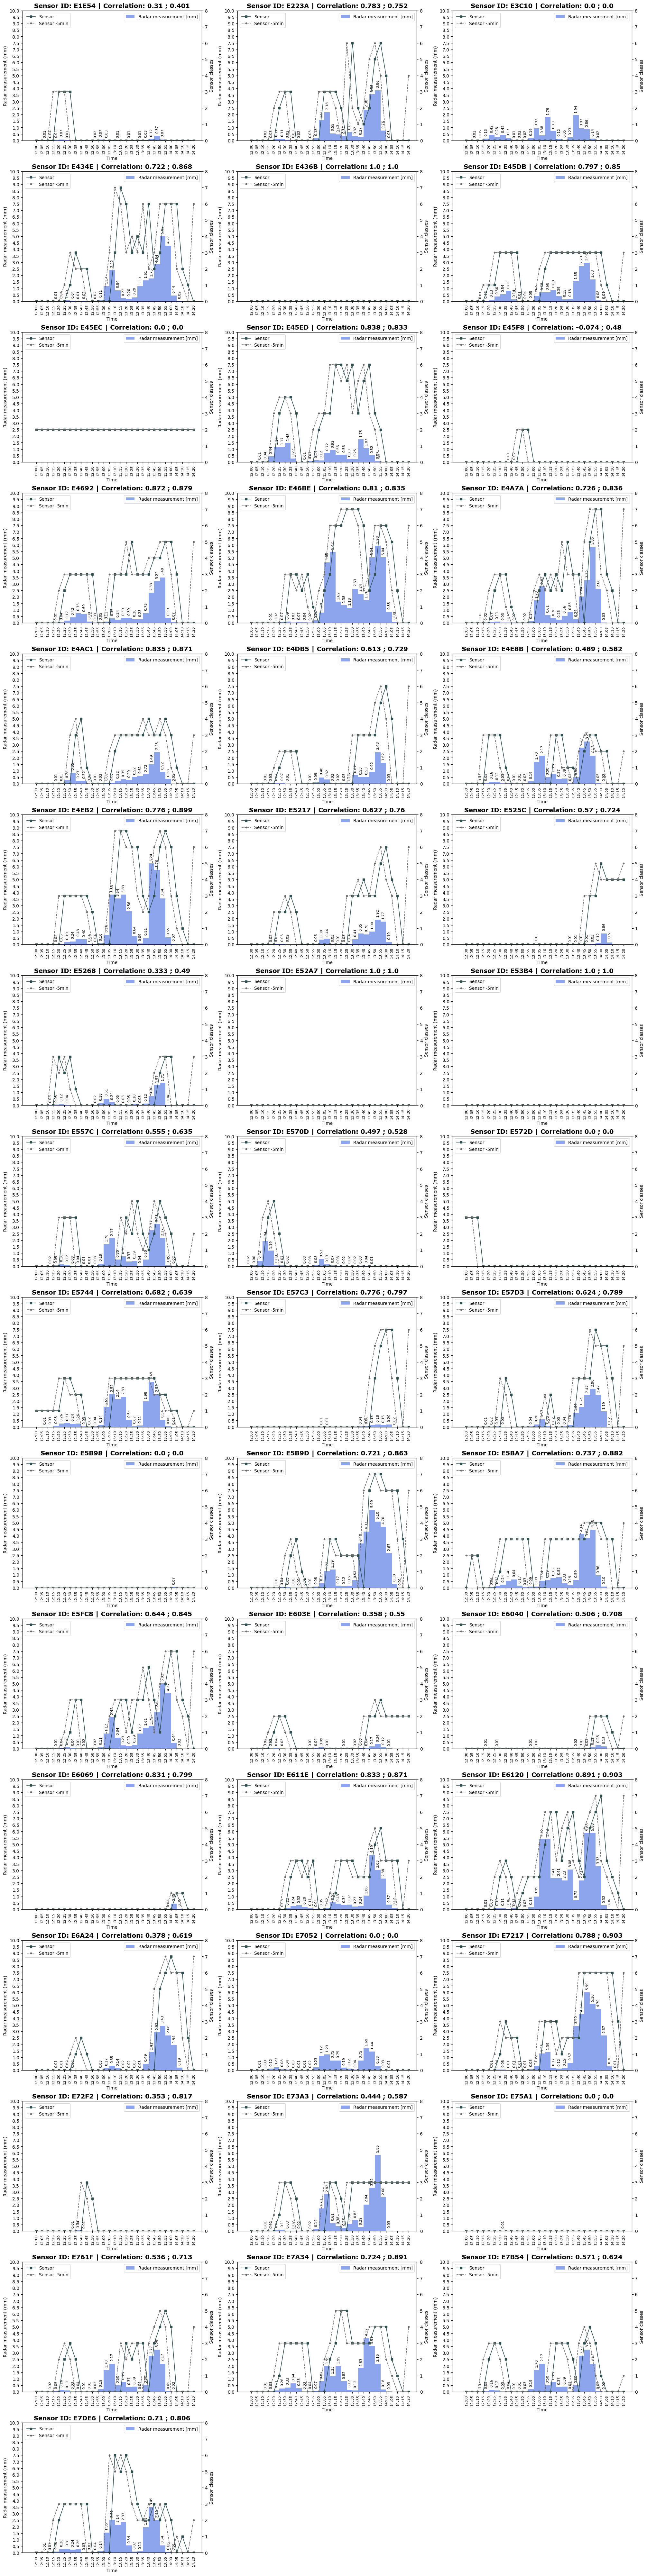

In [18]:
timeseries_df= r'random_event_C\random_event_unmoved.csv'
timeseries_shifted_df=r'random_event_C\random_event_5min.csv'
correlations=r'random_event_C\random_event_correlations.csv'
shifted_timeframe='Sensor -5min'

plot_rain_sensor_correlation(timeseries_df,timeseries_shifted_df, correlations,shifted_timeframe)


## Correlation comparison

C:\Users\thomas\AppData\Local\Temp\ipykernel_5156\1679202692.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(correlation_df[x_col], rotation=90, ha='center')


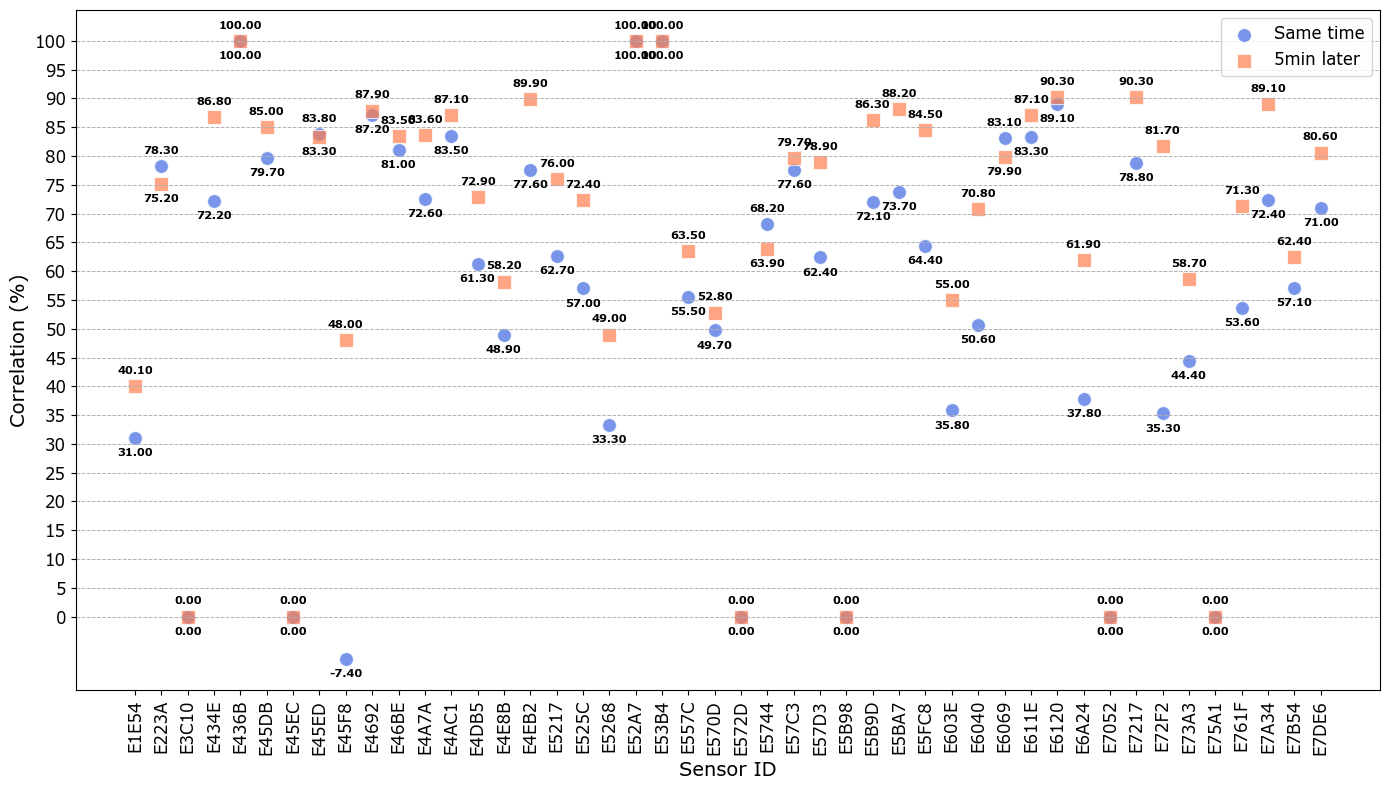

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_correlations(correlation_df, event_path, x_col='deveui', y_col1='spearman', y_col2='spearman_5min', save_plot=False):
    """
    Plots scatter plots for two correlation metrics and annotates points with labels.

    Parameters:
    correlation_df (pd.DataFrame): DataFrame containing the correlation data.
    event_path (str): Path where the plot will be saved if save_plot is True.
    x_col (str): The column to be used for the x-axis (default: 'deveui').
    y_col1 (str): The first correlation column for the y-axis (default: 'spearman').
    y_col2 (str): The second correlation column for the y-axis (default: 'spearman_5min').
    save_plot (bool): Whether to save the plot as a PNG file (default: False).
    """
    # Ensure the x_col is treated as a categorical column to avoid conversion errors
    correlation_df[x_col] = correlation_df[x_col].astype('category')

    # Set default font and font sizes for labels
    plt.rcParams['font.family'] = 'Verdana'
    plt.rcParams['axes.labelsize'] = 14  # Font size for x and y axis labels
    plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis ticks
    plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis ticks
    plt.rcParams['legend.fontsize'] = 12  # Font size for legend

    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot scatter plots for y_col1 and y_col2
    sns.scatterplot(x=x_col, y=y_col1, data=correlation_df, marker='o', label='Same time', 
                    color='royalblue', s=100, ax=ax, edgecolor='w', alpha=0.7)
    sns.scatterplot(x=x_col, y=y_col2, data=correlation_df, marker='s', label='5min later', 
                    color='coral', s=100, ax=ax, edgecolor='w', alpha=0.7)

    # Rotate the x-axis labels
    ax.set_xticklabels(correlation_df[x_col], rotation=90, ha='center')

    # Add labels to each point with conditional vertical alignment and slight offset
    for i in range(len(correlation_df)):
        # Conditional alignment for y_col1 and y_col2
        if correlation_df[y_col1][i] > correlation_df[y_col2][i]:
            va_y1 = 'top'
            va_y2 = 'bottom'
        else:
            va_y1 = 'bottom'
            va_y2 = 'top'

        # Offset to ensure labels do not overlap with markers
        offset_y1 = 3.5 if va_y1 == 'top' else -3.5
        offset_y2 = 3.5 if va_y2 == 'top' else -3.5

        # Annotate y_col1 (formatted to 2 decimal places)
        plt.text(x=correlation_df[x_col][i], y=correlation_df[y_col1][i] + offset_y1, 
                 s=f'{correlation_df[y_col1][i]:.2f}', color='black', ha='center', va=va_y1, fontsize=8, fontweight='bold')

        # Annotate y_col2 (formatted to 2 decimal places)
        plt.text(x=correlation_df[x_col][i], y=correlation_df[y_col2][i] + offset_y2, 
                 s=f'{correlation_df[y_col2][i]:.2f}', color='black', ha='center', va=va_y2, fontsize=8, fontweight='bold')

    # Set y-axis ticks every 5 units
    yticks = range(0, 100 + 5, 5)
    ax.set_yticks(yticks)

    # Add grid lines for better readability
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7)

    # Add labels and title
    ax.set_xlabel("Sensor ID", fontsize=14)
    ax.set_ylabel("Correlation (%)", fontsize=14)

    # Display the legend
    ax.legend()

    # Adjust plot to fit labels and title
    plt.tight_layout()

    # Optionally save the plot
    if save_plot:
        plt.savefig(f"{event_path}correlation_plot.png", dpi=300)

    # Show the plot
    plt.show()

# Example usage
correlation_df = pd.read_csv(f"random_event_C//random_event_correlations.csv", sep=",")
correlation_df['spearman'] = correlation_df['spearman'] * 100
correlation_df['spearman_5min'] = correlation_df['spearman_5min'] * 100
correlation_df.fillna(0, inplace=True)

plot_correlations(correlation_df, event_path='random_event_C\\', save_plot=False)


## Windrose generation

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


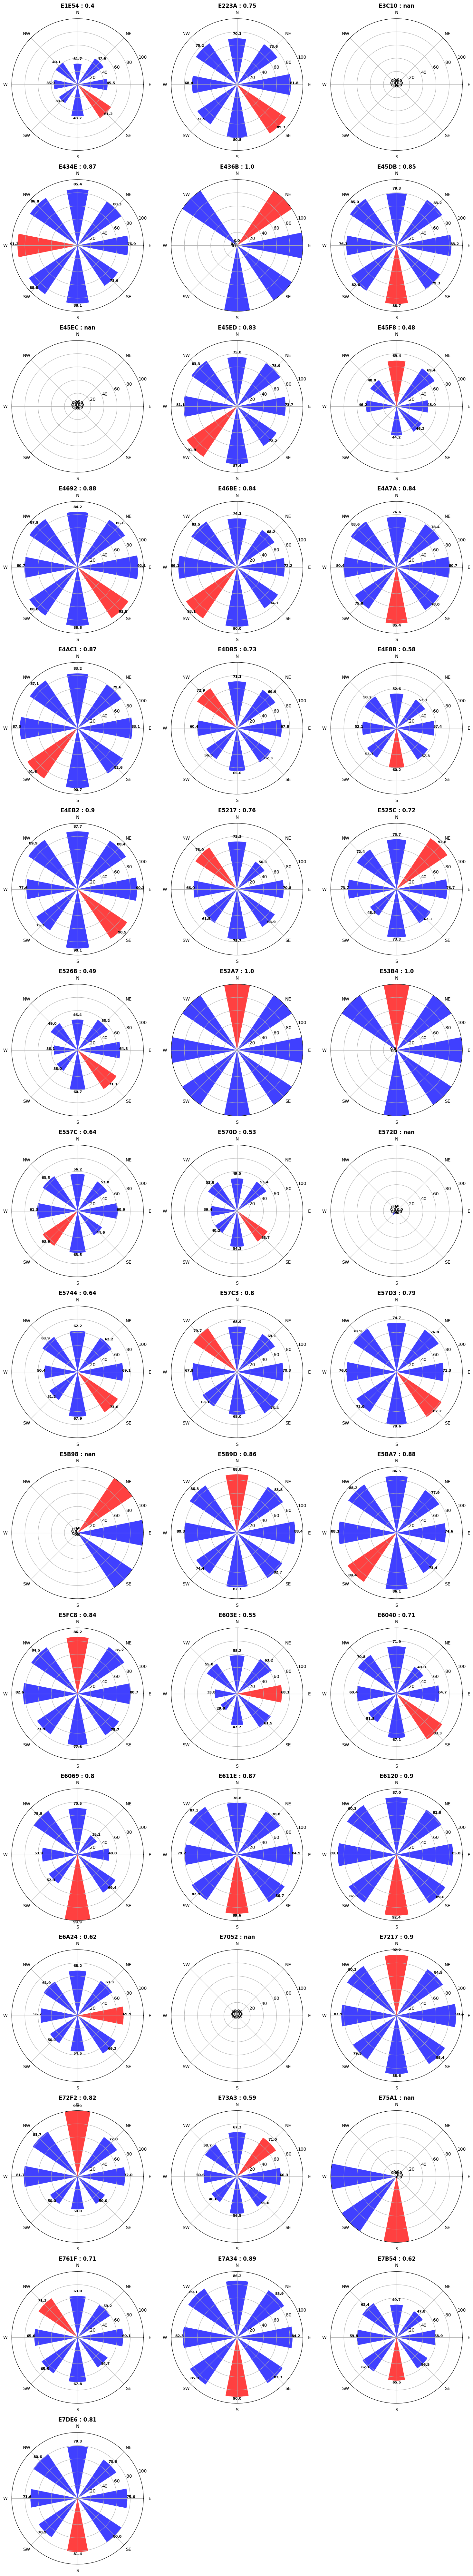

In [25]:
# Generate the windrose graph using the input file from Philip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the base path for the input files and the column name to extract
path = 'random_event\\'
column_data_name = 'spearman_5min'

# Load CSV files for each direction, using only the 'deveui' and correlation columns
northwest = pd.read_csv('random_event_C\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
west = pd.read_csv('random_event_W\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
southwest = pd.read_csv('random_event_SW\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
north = pd.read_csv('random_event_N\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
south = pd.read_csv('random_event_S\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
northeast = pd.read_csv('random_event_NE\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
east = pd.read_csv('random_event_E\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
southeast = pd.read_csv('random_event_SE\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')
center = pd.read_csv('random_event_C\\' + 'random_event_correlations.csv', usecols=['deveui', column_data_name], sep=',')

# Define the number of graphs (46) and the layout for subplots (3 columns)
num_graphs = len(center)
num_columns = 3
num_rows = int(np.ceil(num_graphs / num_columns))  # Calculate the required number of rows

# Create a figure with subplots arranged in a grid (polar projection for windrose)
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows), subplot_kw={'projection': 'polar'})

# Flatten the axes array for easier iteration over subplots
axs = axs.flatten()

# Loop through each device's data (up to 46) and create a polar plot for each
for i in range(num_graphs):
    # Gather correlation data for the current device from all directions
    data = {
        'correlation': [
            north.iloc[i][column_data_name],     # North
            northeast.iloc[i][column_data_name], # Northeast
            east.iloc[i][column_data_name],      # East
            southeast.iloc[i][column_data_name], # Southeast
            south.iloc[i][column_data_name],     # South
            southwest.iloc[i][column_data_name], # Southwest
            west.iloc[i][column_data_name],      # West
            northwest.iloc[i][column_data_name]  # Northwest
        ],
        'direction': ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
    }
    
    # Convert the data into a DataFrame for easier handling
    df = pd.DataFrame(data)
    
    # Scale correlation values (0-100) and replace missing values with 0
    df['correlation'] = df['correlation'] * 100
    df['correlation'] = df['correlation'].fillna(0)
    
    # Dictionary to map directions to angles (in degrees)
    direction_to_angle = {
        'North': 90,
        'Northeast': 45,
        'East': 0,
        'Southeast': 315,
        'South': 270,
        'Southwest': 225,
        'West': 180,
        'Northwest': 135
    }

    # Map the directions to angles in degrees, then convert to radians for plotting
    df['angle'] = df['direction'].map(direction_to_angle)
    df['angle_rad'] = np.deg2rad(df['angle'])

    # Identify the bar with the highest correlation value (to highlight in red)
    max_index = df['correlation'].idxmax()

    # Get the current axis for the subplot and plot the bars
    ax = axs[i]
    bars = ax.bar(df['angle_rad'], df['correlation'], width=np.pi / 8, alpha=0.75,
                  color=['r' if idx == max_index else 'b' for idx in range(len(df))])

    # Set custom labels for the cardinal directions
    ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], fontdict={'fontsize': 10})

    # Add labels on top of each bar, but skip if the correlation is 100
    for bar, correlation, angle in zip(bars, df['correlation'], df['angle_rad']):
        if correlation < 100:  # Avoid labeling bars with a value of 100
            ax.text(angle, bar.get_height() + 5, f'{correlation:.1f}', ha='center', va='bottom', fontsize=8, color='black', fontweight="bold")

    # Get the correlation value from the center region and round it to 2 decimal places
    correlation_center = round(center.iloc[i][1], 2)

    # Set a title for each subplot with the device identifier and the center correlation value
    ax.set_title(f'{south.iloc[i]["deveui"]} : {correlation_center}', fontweight="bold")

    # Set the radial axis limits to range from 0 to 100
    ax.set_ylim(0, 100)

# Hide any extra subplots that are not needed (if there are fewer than 46)
for j in range(num_graphs, len(axs)):
    axs[j].axis('off')

# Adjust layout so that subplots do not overlap
plt.tight_layout()

# Show the final windrose plot
plt.show()
